In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
0
GeForce RTX 3080 Ti


/opt/conda/lib/python3.8/site-packages/torch/_masked/__init__.py:96: UserWarning: Failed to initialize NumPy: module compiled against API version 0xe but this version of numpy is 0xd (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
# !pip install ipywidgets

In [3]:
import numpy as np
from tensorforce import Environment, Runner

class MultiactorEnvironment(Environment):
    """
    Example multi-actor environment, illustrating best-practice implementation pattern.
    State space: position in [0, 10].
    Action space: movement in {-1, 0, 1}.
    Random start in [3, 7].
    Actor 1 perspective as is, actor 2 perspective mirrored.
    Positive reward for being closer to 10.
    """

    def __init__(self):
        super().__init__()

    def states(self):
        return dict(type='int', num_values=11)

    def actions(self):
        return dict(type='int', num_values=3)

    def num_actors(self):
        return 2  # Indicates that environment has multiple actors

    def reset(self):
        # Always for multi-actor environments: initialize parallel indices
        self._parallel_indices = np.arange(self.num_actors())

        # Single shared environment logic, plus per-actor perspective
        self._states = 3 + np.random.randint(5)
        self.second_actor = True
        states = np.stack([self._states, 10 - self._states], axis=0)

        # Always for multi-actor environments: return per-actor values
        return self._parallel_indices.copy(), states

    def execute(self, actions):
        # Single shared environment logic, plus per-actor perspective
        if self.second_actor:
            self.second_actor = self.second_actor and not (np.random.random_sample() < 0.1)
            terminal = np.stack([False, not self.second_actor], axis=0)
            delta = (actions[0] - 1) - (actions[1] - 1)
            self._states = np.clip(self._states + delta, a_min=0, a_max=10)
            states = np.stack([self._states, 10 - self._states], axis=0)
        else:
            terminal = np.stack([False], axis=0)
            delta = (actions[0] - 1)
            self._states = np.clip(self._states + delta, a_min=0, a_max=10)
            states = np.stack([self._states], axis=0)
        reward = (states - 5.0) / 5.0

        # Always for multi-actor environments: update parallel indices, and return per-actor values
        self._parallel_indices = self._parallel_indices[~terminal]
        return self._parallel_indices.copy(), states, terminal, reward


# Multi-actor runner, automatically if environment.num_actors() > 1
runner = Runner(
    agent='json/ppo.json',
    environment=MultiactorEnvironment,
    max_episode_timesteps=10
)


In [4]:
runner.run(num_episodes=1000)


Episodes:   0%|          | 0/1000 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("baseline_optimizer/PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("baseline_optimizer/PartitionedCall:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("baseline_optimizer/PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("policy_optimizer/PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("policy_optimizer/PartitionedCall:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("policy_optimizer/PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [5]:
dir(runner)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'actions',
 'agent',
 'batch_agent_calls',
 'callback',
 'callback_episode_frequency',
 'callback_timestep_frequency',
 'close',
 'environments',
 'episode_agent_second',
 'episode_agent_seconds',
 'episode_return',
 'episode_returns',
 'episode_seconds',
 'episode_start',
 'episode_timestep',
 'episode_timesteps',
 'episodes',
 'evaluation',
 'evaluation_agent_second',
 'evaluation_agent_seconds',
 'evaluation_callback',
 'evaluation_returns',
 'evaluation_run',
 'evaluation_seconds',
 'evaluation_start',
 'evaluation_timesteps',
 'handle_act',
 'handle_act_evaluation',
 'handle_act_joint',
 'handle_observe',
 'handle_ob

In [6]:
runner.updates

1000

In [7]:
runner.agent.spec

OrderedDict([('agent', 'ppo'),
             ('states', {'type': 'int', 'num_values': 11}),
             ('actions', {'type': 'int', 'num_values': 3}),
             ('max_episode_timesteps', 10),
             ('batch_size', 12),
             ('network', {'type': 'auto', 'rnn': False}),
             ('use_beta_distribution', False),
             ('memory', 'minimum'),
             ('update_frequency', 1),
             ('learning_rate', 0.001813150053725916),
             ('multi_step', 5),
             ('subsampling_fraction', 0.9131375430837279),
             ('likelihood_ratio_clipping', 0.09955676846552193),
             ('discount', 0.9985351346308641),
             ('return_processing', None),
             ('advantage_processing', None),
             ('predict_terminal_values', False),
             ('baseline', {'type': 'auto', 'rnn': False}),
             ('baseline_optimizer',
              {'optimizer': 'adam',
               'learning_rate': 0.003670157218888348,
               

In [8]:
import matplotlib.pyplot as plt


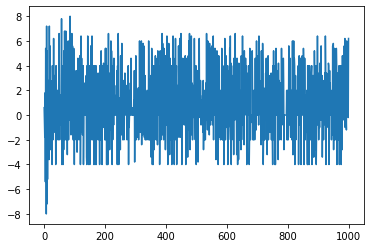

In [9]:
plt.plot(runner.episode_returns)

In [10]:
#https://tensorforce.readthedocs.io/en/0.3.1/runner.html
